In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, log_loss
import plotly.express as px
import numpy as np
import optuna
import matplotlib.pyplot as plt

# Dataset 2 Modeling

In [16]:
df = pd.read_csv('../data/processed/heart_dataset_2_processed.csv')
display(df.shape, df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   amaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    float64
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    float64
 5   hypertension              299 non-null    int64  
 6   platelet_count            299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    float64
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    float64
 12  HeartDisease              299 non-null    int64  
dtypes: float64(7), int64(6)
memory usage: 30.5 KB


(299, 13)

,age,amaemia,creatinine_phosphokinase,diabetes,ejection_fraction,hypertension,platelet_count,serum_creatinine,serum_sodium,sex,smoking,time,HeartDisease
0,1.192945,0,0.000166,0,-1.530560,1,1.681648e-02,0.490057,-1.504036,1,0,-1.629502,1
1,-0.491279,0,7.514640,0,-0.007077,0,7.535660e-09,-0.284552,-0.141976,1,0,-1.603691,1
2,0.350833,0,-0.449939,0,-1.530560,0,-1.038073e+00,-0.090900,-1.731046,1,1,-1.590785,1
3,-0.912335,1,-0.486071,0,-1.530560,0,-5.464741e-01,0.490057,0.085034,1,0,-1.590785,1
4,0.350833,1,-0.435486,1,-1.530560,0,6.517986e-01,1.264666,-4.682176,0,0,-1.577879,1


None

In [17]:
px.imshow(df.corr(),title="Correlation Plot")

### Drop the `HeartDisease` column

In [21]:
k_folds = KFold(n_splits=5)
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

### Split the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### First start with simple Logistic Regression Model

In [27]:
accuracy_log = []
for fold, (train_index, test_index) in enumerate(k_folds.split(X_train, y_train)):
    classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifier.fit(X_train.iloc[train_index], y_train.iloc[train_index])

    X_valid = X_train.iloc[test_index]
    y_valid = y_train.iloc[test_index]
    y_pred = classifier.predict(X_valid)

    print(f"\n📂 Fold {fold + 1}")
    print(classification_report(y_valid, y_pred))

    acc = roc_auc_score(y_valid, y_pred)
    accuracy_log.append(acc)
    print(f"ROC AUC Score for Fold {fold + 1}: {acc:.4f}")

print("\nCross-Validation Summary:")
print(f"Mean ROC AUC: {np.mean(accuracy_log):.4f}")
print(f"Standard Deviation: {np.std(accuracy_log):.4f}")


📂 Fold 1
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        32
           1       1.00      0.50      0.67        16

    accuracy                           0.83        48
   macro avg       0.90      0.75      0.78        48
weighted avg       0.87      0.83      0.81        48

ROC AUC Score for Fold 1: 0.7500

📂 Fold 2
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        31
           1       0.87      0.76      0.81        17

    accuracy                           0.88        48
   macro avg       0.87      0.85      0.86        48
weighted avg       0.87      0.88      0.87        48

ROC AUC Score for Fold 2: 0.8501

📂 Fold 3
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        31
           1       0.65      0.65      0.65        17

    accuracy                           0.75        48
   macro avg       0.73      0.7

### Tune Logistic Regression model using Optuna

In [73]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
def objective_accuracy(trial,X,y):
    C = trial.suggest_float("C",1e-3,10,log=True)
    accuracy_log = np.array([])
    for fold, (train_index, test_index) in enumerate(k_folds.split(X_train)):
        classifier = LogisticRegression(C=C)
        classifier.fit(X_train.iloc[train_index],y_train.iloc[train_index])
        X_valid = X_train.iloc[test_index]
        y_pred=classifier.predict(X_valid)
        y_valid = y_train.iloc[test_index]
        acc=roc_auc_score(y_valid,y_pred)
        accuracy_log = np.append(accuracy_log,acc)
    return np.mean(accuracy_log)

In [74]:
study_name = 'accuracy_dataset2'
storage_name_db = "sqlite:///../optuna_database/"+study_name+".db"
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize',study_name=study_name,load_if_exists=True,storage=storage_name_db)
study.optimize(lambda trial: objective_accuracy(trial, X_train, y_train), n_trials = 50)
print('numbers of the finished trials:' , len(study.trials))
print('the best params:' , study.best_trial.params)
print('the best accuracy:' , study.best_value)

numbers of the finished trials: 50
the best params: {'C': 0.2579364203258358}
the best accuracy: 0.8050097125097124


In [75]:
def objective_l1(trial,X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
    C = trial.suggest_float("C",1e-3,10,log=True)
    l1_log = np.array([])
    for fold, (train_index, test_index) in enumerate(k_folds.split(X_train)):
        classifier = LogisticRegression(C=C)
        classifier.fit(X_train.iloc[train_index],y_train.iloc[train_index])
        X_valid = X_train.iloc[test_index]
        y_pred=classifier.predict_proba(X_valid)
        y_valid = y_train.iloc[test_index]
        l1 = log_loss(y_valid,y_pred)
        l1_log = np.append(l1_log,l1)
        # acc=roc_auc_score(y_valid,y_pred)
        # accuracy_log = np.append(accuracy_log,acc)
    return np.mean(l1_log)

In [76]:
study_name = 'l1_dataset2'
storage_name_db = "sqlite:///../optuna_database/"+study_name+".db"
study = optuna.create_study(direction='minimize',study_name=study_name,load_if_exists=True,storage=storage_name_db)
study.optimize(lambda trial: objective_l1(trial, X_train, y_train), n_trials = 50)
print('numbers of the finished trials:' , len(study.trials))
print('the best params:' , study.best_trial.params)
print('the best l1:' , study.best_value)

numbers of the finished trials: 50
the best params: {'C': 0.23958567520972715}
the best l1: 0.3685440823461436


In [77]:
study_number = 0 ######## Edit this number to switch between studies
study_name_set = ["accuracy_dataset2","l1_dataset2"]
storage_name_set_db = "sqlite:///../optuna_database/"+study_name_set[study_number]+".db"
study_plot = optuna.load_study(study_name = study_name_set[study_number], storage=storage_name_set_db)

In [78]:
dataframe = study_plot.trials_dataframe()
if(study_number == 0):
    accuracy = dataframe['value']
elif(study_number == 1):
    l1 = dataframe['value']
C = dataframe['params_C']
trial_number = dataframe['number']

In [79]:
dataframe.head()

,number,value,datetime_start,datetime_complete,duration,params_C,state
0,0,0.508333,2025-04-29 17:50:00.035428,2025-04-29 17:50:00.061111,0 days 00:00:00.025683,0.003646,COMPLETE
1,1,0.500000,2025-04-29 17:50:00.067034,2025-04-29 17:50:00.084878,0 days 00:00:00.017844,0.001568,COMPLETE
2,2,0.796334,2025-04-29 17:50:00.089024,2025-04-29 17:50:00.106252,0 days 00:00:00.017228,6.885534,COMPLETE
3,3,0.537917,2025-04-29 17:50:00.110049,2025-04-29 17:50:00.125893,0 days 00:00:00.015844,0.006935,COMPLETE
4,4,0.796334,2025-04-29 17:50:00.130905,2025-04-29 17:50:00.147873,0 days 00:00:00.016968,2.368930,COMPLETE


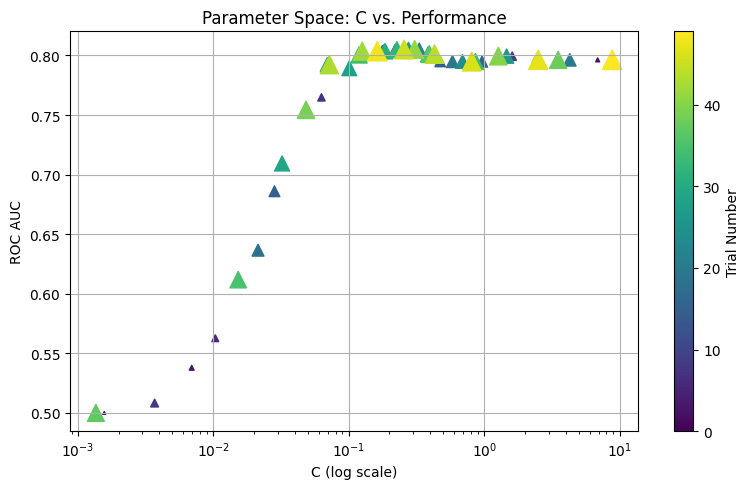

In [83]:
import matplotlib.pyplot as plt

colors = plt.get_cmap('viridis')
plt.figure(figsize=(8,5))
plt.scatter(
    C,
    dataframe['value'],
    s=4 * trial_number,
    marker='^',
    c=trial_number,
    cmap=colors
)
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("ROC AUC" if study_number == 0 else "Log Loss")
plt.title("Parameter Space: C vs. Performance")
plt.colorbar(label="Trial Number")
plt.grid(True)
plt.tight_layout()
plt.show()


### Now get best C and train final model and view results

In [ ]:
study_name = 'accuracy_dataset2'
storage_name = f"sqlite:///../optuna_database/{study_name}.db"

study = optuna.load_study(study_name=study_name, storage=storage_name)
best_c = study.best_trial.params['C']
print("Best C:", best_c)

Best C: 0.2579364203258358


In [87]:
final_model = LogisticRegression(
    C=best_c,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

final_model.fit(X_train, y_train)

y_probs = final_model.predict_proba(X_test)[:, 1]
y_preds = final_model.predict(X_test)

print("ROC AUC:", roc_auc_score(y_test, y_preds))
print("Accuracy:", accuracy_score(y_test, y_preds))
print("Log Loss:", log_loss(y_test, y_probs))
print("Classification Report:\n", classification_report(y_test, y_preds))

ROC AUC: 0.8055198973042362
Accuracy: 0.85
Log Loss: 0.3941816372544925
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89        41
           1       0.81      0.68      0.74        19

    accuracy                           0.85        60
   macro avg       0.84      0.81      0.82        60
weighted avg       0.85      0.85      0.85        60

